# Libraries importing

In [1]:
from collections import defaultdict
import math
import os
import pickle
import requests
import sys
import warnings

import catboost
from catboost import CatBoostRegressor, Pool
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

print('Python:'.ljust(16), sys.version.split('\n')[0])
print('Scikit-learn:'.ljust(16), sklearn.__version__)
print('CatBoost:'.ljust(16), catboost.__version__)

Python:          3.10.9 (v3.10.9:1dd9be6584, Dec  6 2022, 14:37:36) [Clang 13.0.0 (clang-1300.0.29.30)]
Scikit-learn:    1.3.0
CatBoost:        1.2.1


In [2]:
# Save requirements
!pip freeze > requirements.txt

# Constants definition

In [3]:
DATA_PATH = './data/'
MODELS_PATH = './models/'
RANDOM_STATE = 424242
VALIDATION_SIZE = 0.2

TRAIN = 'TRAIN'  # Feature to separate training and validation parts
TARGET = 'Цена'  # Target feature

# Dataset parsing

In [4]:
def get_links(base_url, pages):
    links = []
    for page in pages:
        # Get response from page
        response = requests.get(url + str(page))

        # Check response status
        if response.status_code == 200:
            print(f'Page {page} received')

            # Find links on a page
            soup = BeautifulSoup(response.content, 'html.parser')
            for a in soup.find_all(class_='adv-list-image__link'):
                links.append('http://citystar.ru/' + a['href'])
        else:
            print(f'Page {page} error: code {response.status_code}')

    return links


def get_data_from_links(links):
    data = defaultdict(list)
    for link in links:
        # Append link to data
        data['link'].append(link)
        
        # Get response from page
        response = requests.get(link)
        
        # Check response status
        if response.status_code == 200:
            # Find data on a page
            soup = BeautifulSoup(response.content, 'html.parser')
            soup = soup.find(class_='data-table')
            soup = soup.find_all(class_='fin')
            for k, v in zip(soup[0::2], soup[1::2]):
                data[str(k.contents[0])].append(str(v.contents[0]) if len(v.contents) > 0 else None)
        else:
            print(f'Page {link} error: code {response.status_code}')

    return pd.DataFrame(data)

In [5]:
%%time
data_file = DATA_PATH + 'data.pickle'
url = 'http://citystar.ru/detal.htm?d=43&pN='
pages = range(1, 6)

# Check if data file is already exists
if os.path.isfile(data_file):
    # Load data from disk
    df = pd.read_pickle(data_file)
else:
    # Parse data from the Internet
    links = get_links(url, pages)
    df = get_data_from_links(links)

    # Save data to disk
    df.to_pickle(data_file)

CPU times: user 2.67 ms, sys: 1.72 ms, total: 4.39 ms
Wall time: 4.23 ms


In [6]:
df.head()

,link,Дата подачи,Дата обновления,Примечание,Тип квартиры,Район,Адрес,Дом,Этаж,Планировка,о,ж,к,цена (т.р.),Телефон,Имя,E-mail,Просмотров:
0,http://citystar.ru/scard.asp?d=43&id=15909831,30.08.2023 15:22:27,02.09.2023 14:03:02,В продаже 4-х комнатная квартира. С хорошим ре...,Трехкомнатная,Орджоникидзевский,Труда,14,8/9,None,80.00,53.00,9.00,5999,8-902-619-83-08,Юлия Юрьевна,None,40
1,http://citystar.ru/scard.asp?d=43&id=15909830,30.08.2023 14:57:57,02.09.2023 14:02:56,Продается 4-х комнатная квартира нестандартной...,Четырехкомнатная,Орджоникидзевский,Труда,18,9/9,None,79.00,52.70,8.20,6350,8-902-619-83-08,Юлия Юрьевна,None,27
2,http://citystar.ru/scard.asp?d=43&id=15927949,02.09.2023 14:02:00,02.09.2023 14:02:21,Продам 3-х комнатную квартиру\r\nпремиум-класс...,Трехкомнатная,Орджоникидзевский,Ленина пр-т,129/2,6/9,None,105.00,78.00,14.00,8700,89026198308,Юлия Юрьевна,None,6
3,http://citystar.ru/scard.asp?d=43&id=15927071,02.09.2023 8:11:48,02.09.2023 8:11:48,id:26867. \r\nВНИМАНИЕ! ЭКСКЛЮЗИВНОЕ ПРЕДЛОЖЕН...,Многокомнатная,None,Калмыкова,14,8/9,None,65.00,45.00,8.00,4800,79193209269,Руслан Жаксалыков,ruslanjaksalykov.riolux@gmail.com,10
4,http://citystar.ru/scard.asp?d=43&id=15927070,02.09.2023 8:11:47,02.09.2023 8:11:47,id:26185. \r\nП продаже отличная двухкомнатная...,Двухкомнатная,None,Суворова,136/1,2/5,None,44.30,30.00,6.00,2980,79026009666,Алия Тугузова,tuguzova.riolux@gmail.com,7


# Dataset preprocessing

In [7]:
# Set housing ID as an index
df['id'] = df['link'].str.split('=', regex=False, expand=True)[2].astype(int)
df.set_index('id', inplace=True, verify_integrity=True)

# Expand 'Этаж' column
df[['Этаж', 'Этажей']] = df['Этаж'].str.split('/', regex=False, expand=True).astype(int)

# Cast column types
df['цена (т.р.)'] = df['цена (т.р.)'].astype(int)
df[['о', 'ж', 'к']] = df[['о', 'ж', 'к']].astype(float)

# Drop useless columns
columns = ['link', 'Дата подачи', 'Дата обновления', 'Примечание', 'Дом', 'Телефон', 'Имя', 'E-mail', 'Просмотров:']
df.drop(columns=columns, inplace=True)

# Rename column
df.rename(columns={'цена (т.р.)': TARGET}, inplace=True)
df.rename(columns={'Адрес': 'Улица'}, inplace=True)

# Drop rows without 'Тип квартиры'
nan_indices = df.loc[df['Тип квартиры'].isna()].index
df.drop(nan_indices, inplace=True)

# Drop rows where 'Цена' equals to zero
zero_price_indices = df.loc[df[TARGET] == 0].index
df.drop(zero_price_indices, inplace=True)

# Change wrong values
df.loc[df['Этаж'] == -1, 'Этаж'] = 1
df.loc[df['Район'] == 'орджоникидзевский', 'Район'] = 'Орджоникидзевский'
df.loc[df['Район'] == 'Ленинский (Левый берег)', 'Район'] = 'Ленинский'
df.loc[df['Район'] == 'правобережный', 'Район'] = 'Правобережный'
df.loc[df['Район'] == 'Правобережный район', 'Район'] = 'Правобережный'
df.loc[df['Планировка'] == 'Улучшенная', 'Планировка'] = 'улучшенная'
df['Улица'] = df['Улица'].str.lower()
df['Улица'] = df['Улица'].str.replace('ул ', '', n=1, regex=False)
df['Улица'] = df['Улица'].str.replace('ул.', '', n=1, regex=False)
df['Улица'] = df['Улица'].str.replace(r'\d+', '', regex=True)
df['Улица'] = df['Улица'].str.replace(r'[.,/"-]', '', regex=True)
df['Улица'] = df['Улица'].str.replace('прт', '', n=1, regex=False)
df['Улица'] = df['Улица'].str.replace('проспект', '', n=1, regex=False)
df['Улица'] = df['Улица'].str.replace('им ', '', n=1, regex=False)
df['Улица'] = df['Улица'].str.replace('имени ', '', n=1, regex=False)
df['Улица'] = df['Улица'].str.replace(' к', '', n=1, regex=False)
df['Улица'] = df['Улица'].str.strip()

# Correct street names
df.loc[df['Улица'] == 'ленина', 'Улица'] = 'Проспект Ленина'
df.loc[df['Улица'] == 'карла маркса', 'Улица'] = 'Карла Маркса'
df.loc[df['Улица'] == 'советская', 'Улица'] = 'Советская'
df.loc[df['Улица'] == 'зеленый лог', 'Улица'] = 'Зеленый Лог'
df.loc[df['Улица'] == 'труда', 'Улица'] = 'Труда'
df.loc[df['Улица'] == 'летия магнитки', 'Улица'] = '50-летия Магнитки'
df.loc[df['Улица'] == 'газеты правда', 'Улица'] = 'Газеты Правда'
df.loc[df['Улица'] == 'урортная', 'Улица'] = 'Курортная'
df.loc[df['Улица'] == 'грязнова', 'Улица'] = 'Грязнова'
df.loc[df['Улица'] == 'суворова', 'Улица'] = 'Суворова'
df.loc[df['Улица'] == 'московская', 'Улица'] = 'Московская'
df.loc[df['Улица'] == 'уральская', 'Улица'] = 'Уральская'
df.loc[df['Улица'] == 'коробова', 'Улица'] = 'Коробова'
df.loc[df['Улица'] == 'металлургов', 'Улица'] = 'Металлургов'
df.loc[df['Улица'] == 'октябрьская', 'Улица'] = 'Октябрьская'
df.loc[df['Улица'] == 'тевосяна', 'Улица'] = 'Тевосяна'
df.loc[df['Улица'] == 'ворошилова', 'Улица'] = 'Ворошилова'

# Split dataframe on train and validation parts
_, valid_idx = train_test_split(
    range(len(df)),
    test_size=VALIDATION_SIZE,
    random_state=RANDOM_STATE,
    stratify=df['Тип квартиры'],
)
df[TRAIN] = True
df.loc[df.iloc[valid_idx].index, TRAIN] = False

In [8]:
df.head()

,Тип квартиры,Район,Улица,Этаж,Планировка,о,ж,к,Цена,Этажей,TRAIN
id,,,,,,,,,,,
15909831,Трехкомнатная,Орджоникидзевский,Труда,8,None,80.0,53.0,9.0,5999,9,True
15909830,Четырехкомнатная,Орджоникидзевский,Труда,9,None,79.0,52.7,8.2,6350,9,True
15927949,Трехкомнатная,Орджоникидзевский,Проспект Ленина,6,None,105.0,78.0,14.0,8700,9,True
15927071,Многокомнатная,None,калмыкова,8,None,65.0,45.0,8.0,4800,9,True
15927070,Двухкомнатная,None,Суворова,2,None,44.3,30.0,6.0,2980,5,True


**Comments**
___
Make a deep copy of the dataframe to use it with linear ML methods. Trees based methods are not sensitive to outliers, scale, linear dependense and some of theese can work with missing values.

In [9]:
# Make a deep copy of the dataframe to use it with linear ML methods
df_linear_ml = df.copy()

# Exploratory data analysis
## General info
### Dataframe info

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 456 entries, 15909831 to 12926993
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Тип квартиры  456 non-null    object 
 1   Район         286 non-null    object 
 2   Улица         452 non-null    object 
 3   Этаж          456 non-null    int64  
 4   Планировка    123 non-null    object 
 5   о             456 non-null    float64
 6   ж             456 non-null    float64
 7   к             456 non-null    float64
 8   Цена          456 non-null    int64  
 9   Этажей        456 non-null    int64  
 10  TRAIN         456 non-null    bool   
dtypes: bool(1), float64(3), int64(3), object(4)
memory usage: 55.8+ KB


In [11]:
print('Number of unique ids:', df.index.nunique())

Number of unique ids: 456


In [12]:
print('Number of training objects:  ', len(df.loc[df[TRAIN]]))
print('Number of validation objects:', len(df.loc[~df[TRAIN]]))

Number of training objects:   364
Number of validation objects: 92


### Value counts

In [13]:
categ_columns = ['Тип квартиры', 'Район', 'Улица', 'Планировка']

for column in categ_columns:
    print(df[column].value_counts())
    print()

Тип квартиры
Двухкомнатная       173
Трехкомнатная       142
Однокомнатная       113
Четырехкомнатная     21
Многокомнатная        7
Name: count, dtype: int64

Район
Орджоникидзевский                  113
Ленинский                           86
Правобережный                       75
Орджоникидзевский (левый берег)     12
Name: count, dtype: int64

Улица
Проспект Ленина    67
Карла Маркса       55
Советская          19
Зеленый Лог        19
Труда              16
                   ..
корсикова           1
уйбышева            1
тургенева           1
достоевского        1
дружбы              1
Name: count, Length: 99, dtype: int64

Планировка
улучшенная              24
брежневка               22
нестандартная           20
старой планировки       17
раздельная              11
хрущевка                 7
сталинский вариант       5
свердловский вариант     4
ленинградский проект     3
малосемейка              3
гребенка                 3
полусмежная              1
полустудия               1
ра

In [14]:
df['Этаж'].value_counts()

Этаж
1     112
2      95
5      75
3      57
4      39
7      26
9      17
6      17
8       8
13      3
10      3
14      2
11      2
Name: count, dtype: int64

In [15]:
df['Этажей'].value_counts()

Этажей
5     145
9      84
3      53
10     42
4      39
2      38
1      23
14     14
16      9
12      3
8       2
13      1
6       1
17      1
7       1
Name: count, dtype: int64

## Correlation analysis
### Correlation matrix

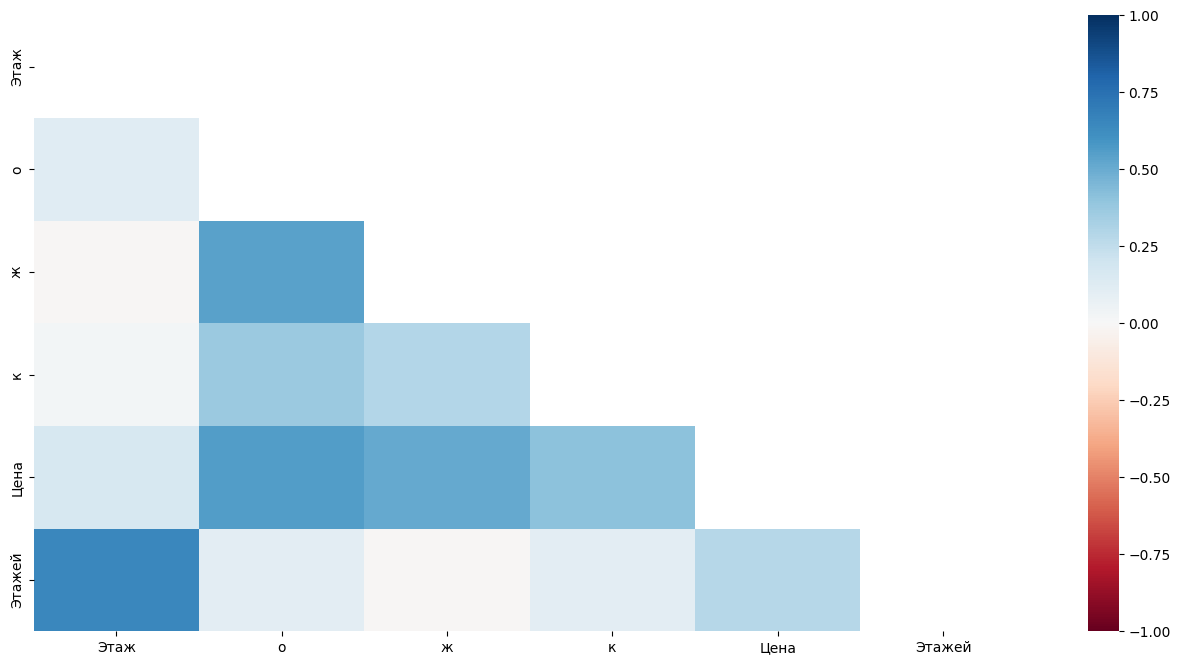

In [16]:
# Compute correlation table
corr = df.drop(columns=categ_columns + [TRAIN]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.subplots(figsize=(16, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap="RdBu");

### Correlation with target

In [17]:
# Sort absolute correlation values with target variable
corr[TARGET].abs().sort_values(ascending=False)

Цена      1.000000
о         0.559677
ж         0.510923
к         0.406383
Этажей    0.284088
Этаж      0.168814
Name: Цена, dtype: float64

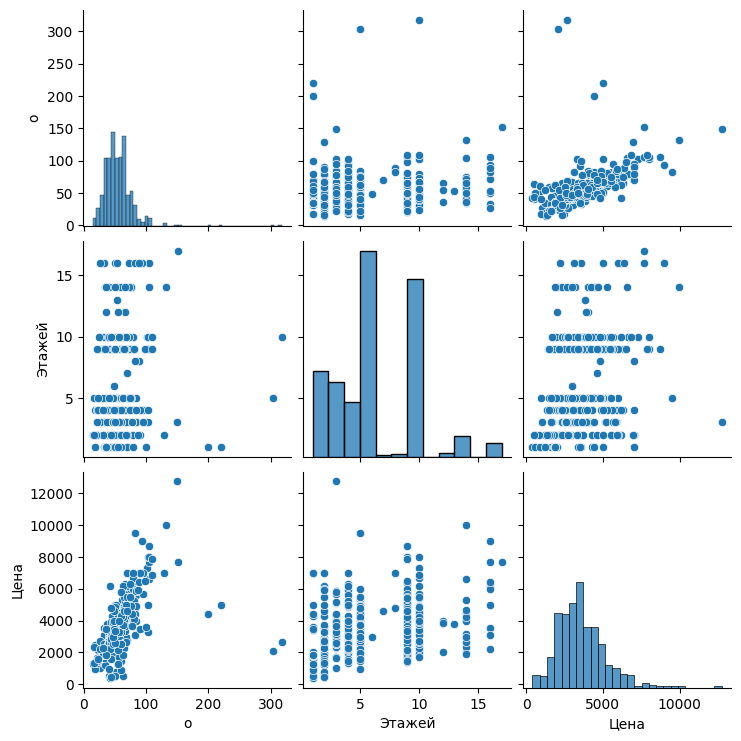

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.pairplot(df[['о', 'Этажей', TARGET]]);

### Searching for strong correlations

In [19]:
# Correlation threshold
corr_threshold = 0.90

# Triangle mask
triangle_mask = np.triu(np.ones_like(corr, dtype=bool))

# Mask correlations below threshold value
corr_mask = corr.mask(triangle_mask).where(corr.abs() > corr_threshold)

# Show onle strong correlations
strong_corr = corr_mask.dropna(axis=0, how='all').dropna(axis=1, how='all')
strong_corr

""


**Comments**
___
There is no strong correlation values that can interfere with calculations by linear models.

## Missing values
### Showing of missing values

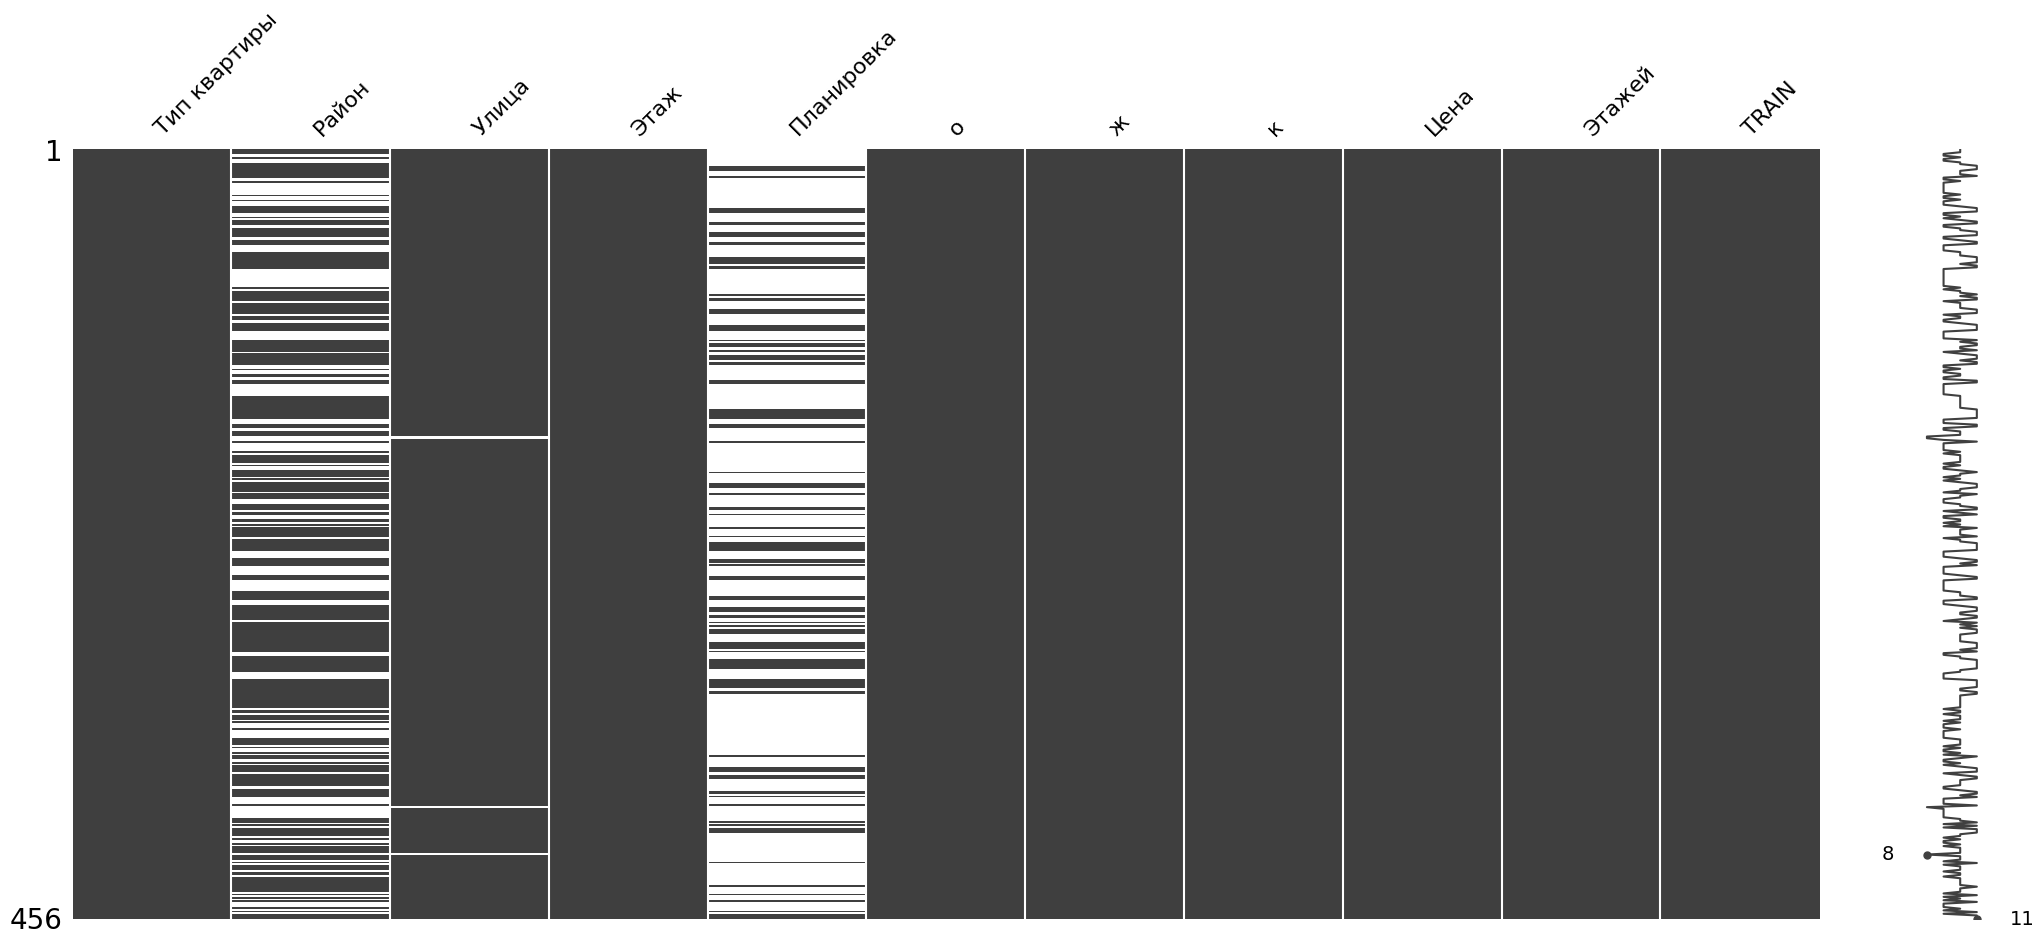

In [20]:
missingno.matrix(df);

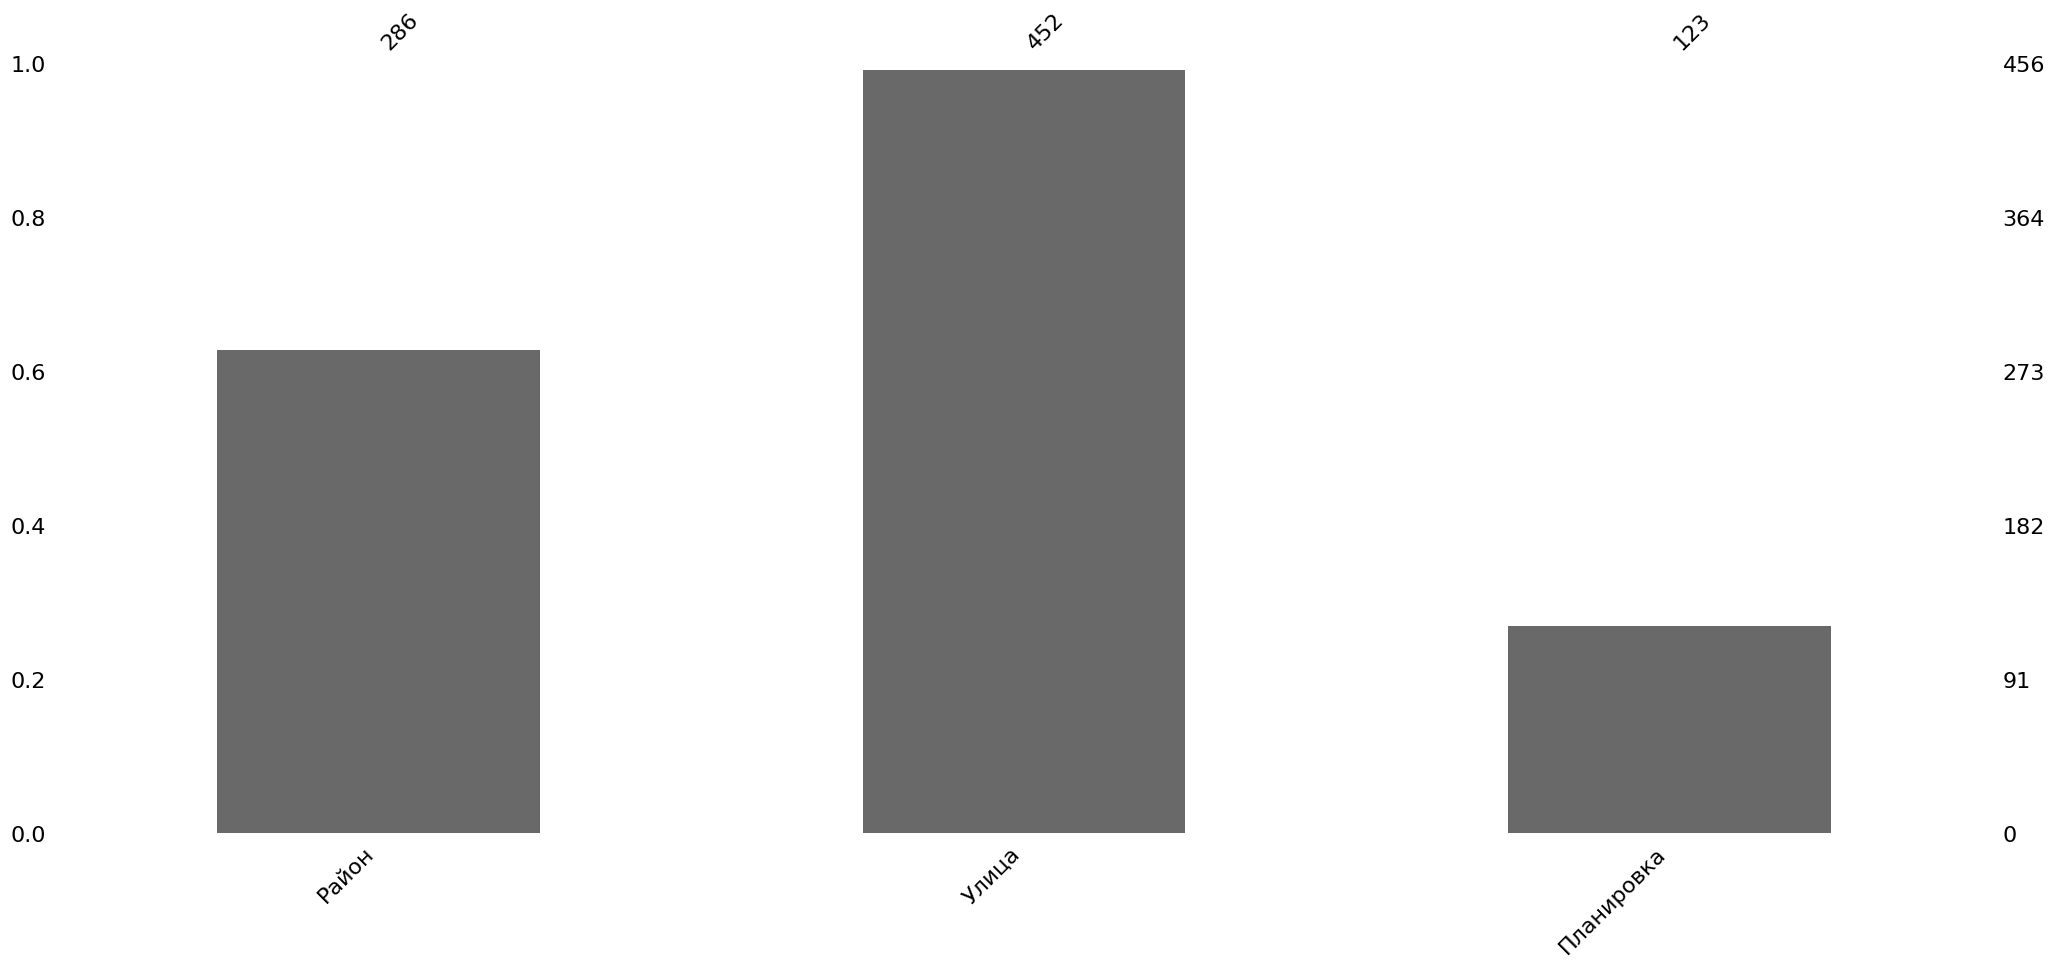

In [21]:
missingno.bar(df, filter='bottom', n=3);

## Outliers
### Showing of boxplots

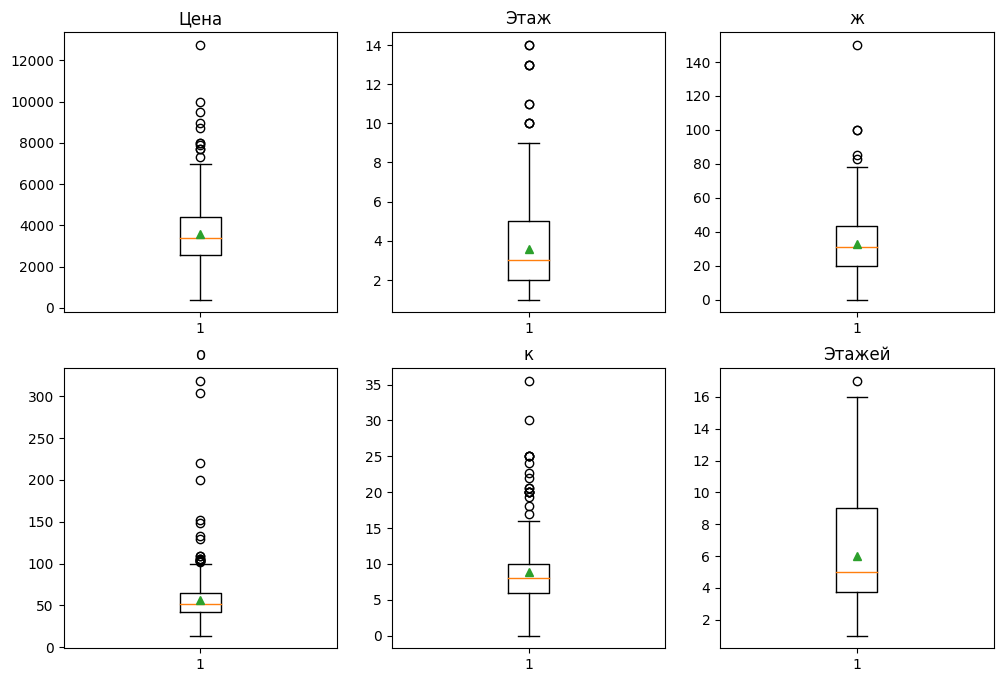

In [22]:
# Define columns to plot
plot_columns = set(df.columns.to_list()) - set(categ_columns + [TRAIN])

# Create figure with [rows x cols] graphs
cols = 3
rows = math.ceil((len(plot_columns)) / cols)
fig, axs = plt.subplots(rows, cols, figsize=(12, rows*4))

# Plot graphs
for i, column in enumerate(plot_columns):
    if rows == 1:
        idx = i%cols
    else:
        idx = (i//cols, i%cols)
    axs[idx].boxplot(df_linear_ml.loc[df_linear_ml[column].notna(), column], showmeans=True)
    axs[idx].set_title(column)

In [23]:
outliers = {}
outliers_num = {}
for column in plot_columns:
    # Calculate Q1, Q3, IQR
    Q1 = df_linear_ml[column].quantile(0.25)
    Q3 = df_linear_ml[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate indices of rows
    outliers[column] = list(df_linear_ml.loc[(~df_linear_ml[column].between(Q1 - 1.5*IQR, Q3 + 1.5*IQR))
                            & (df_linear_ml[column].notna()), column].index)
    outliers_num[column] = len(outliers[column])

print('Number of outliers per column:')
pd.Series(outliers_num).sort_values(ascending=False)

Number of outliers per column:


к         19
о         18
Цена      11
Этаж      10
ж          5
Этажей     1
dtype: int64

# Categorical encoding

In [24]:
encoder = OneHotEncoder(sparse_output=False, min_frequency=7, handle_unknown='infrequent_if_exist')
encoded_train = pd.DataFrame(encoder.fit_transform(df.loc[df[TRAIN], categ_columns]), df.loc[df[TRAIN]].index, encoder.get_feature_names_out())
encoded_valid = pd.DataFrame(encoder.transform(df.loc[~df[TRAIN], categ_columns]), df.loc[~df[TRAIN]].index, encoder.get_feature_names_out())
encoded = pd.concat([encoded_train, encoded_valid])
df_encoded = pd.concat([df, encoded], axis=1).drop(columns=categ_columns)

# Data splitting

In [25]:
# Split data
x = df.drop(columns=[TRAIN, TARGET])
y = df[TARGET]
x_train = df.loc[df[TRAIN], :].drop(columns=[TRAIN, TARGET])
x_valid = df.loc[~df[TRAIN], :].drop(columns=[TRAIN, TARGET])
y_train = df.loc[df[TRAIN], TARGET]
y_valid = df.loc[~df[TRAIN], TARGET]

# Split encoded data
x_encoded = df_encoded.drop(columns=[TRAIN, TARGET])
y_encoded = df_encoded[TARGET]
x_train_encoded = df_encoded.loc[df_encoded[TRAIN], :].drop(columns=[TRAIN, TARGET])
x_valid_encoded = df_encoded.loc[~df_encoded[TRAIN], :].drop(columns=[TRAIN, TARGET])
y_train_encoded = df_encoded.loc[df_encoded[TRAIN], TARGET]
y_valid_encoded = df_encoded.loc[~df_encoded[TRAIN], TARGET]

# Print data shape
print('Data shapes:        ', x.shape, x_train.shape, x_valid.shape, y.shape, y_train.shape, y_valid.shape)
print('Encoded data shapes:', x_encoded.shape, x_train_encoded.shape, x_valid_encoded.shape, y_encoded.shape,
      y_train_encoded.shape, y_valid_encoded.shape)

Data shapes:         (456, 9) (364, 9) (92, 9) (456,) (364,) (92,)
Encoded data shapes: (456, 37) (364, 37) (92, 37) (456,) (364,) (92,)


# Dummy Regressor

In [26]:
def evaluate(model, x_train, y_train, x_valid, y_valid):
    pred_train = model.predict(x_train)
    pred_valid = model.predict(x_valid)
    
    mae_train = mean_absolute_error(y_train, pred_train)
    mae_valid = mean_absolute_error(y_valid, pred_valid)
    
    rmse_train = math.sqrt(mean_squared_error(y_train, pred_train))
    rmse_valid = math.sqrt(mean_squared_error(y_valid, pred_valid))

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_valid = mean_absolute_percentage_error(y_valid, pred_valid)
    
    print(f'Training MAE:    {int(mae_train)} т.р.')
    print(f'Validation MAE:  {int(mae_valid)} т.р.')
    print()
    print(f'Training RMSE:   {int(rmse_train)} т.р.')
    print(f'Validation RMSE: {int(rmse_valid)} т.р.')
    print()
    print(f'Training MAPE:   {(mape_train*100):.2f} %')
    print(f'Validation MAPE: {(mape_valid*100):.2f} %')
    
    return mae_train, mae_valid, rmse_train, rmse_valid, mape_train, mape_valid

In [27]:
# Define model
model = DummyRegressor()

# Train model
model.fit(x_train, y_train)

# Evaluate model
evaluate(model, x_train, y_train, x_valid, y_valid);

Training MAE:    1185 т.р.
Validation MAE:  1186 т.р.

Training RMSE:   1598 т.р.
Validation RMSE: 1513 т.р.

Training MAPE:   50.46 %
Validation MAPE: 42.88 %


# Decision Tree Regressor
## Fit

In [28]:
%%time
model_file = MODELS_PATH + 'decision_tree.pickle'

# Check if the model is already exists
if os.path.isfile(model_file):
    # Load model
    with open(model_file, 'rb') as f:
        model = pickle.load(f)
else:
    # Train model
    model = DecisionTreeRegressor(random_state=RANDOM_STATE)
    model.fit(x_train_encoded, y_train_encoded)

    # Save model
    with open(model_file, 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 3.27 ms, sys: 1.25 ms, total: 4.52 ms
Wall time: 4.31 ms


## Evaluate

In [29]:
evaluate(model, x_train_encoded, y_train_encoded, x_valid_encoded, y_valid_encoded);

Training MAE:    0 т.р.
Validation MAE:  800 т.р.

Training RMSE:   5 т.р.
Validation RMSE: 1202 т.р.

Training MAPE:   0.02 %
Validation MAPE: 22.78 %


**Comments**
___
The model has overfitted. Searching for hyperparameter is needed.

# Random Forest Regressor
## Fit

In [30]:
%%time
model_file = MODELS_PATH + 'random_forest.pickle'

# Check if the model is already exists
if os.path.isfile(model_file):
    # Load model
    with open(model_file, 'rb') as f:
        model = pickle.load(f)
else:
    # Train model
    model = RandomForestRegressor(n_estimators=100, max_features=0.3,
                                  n_jobs=-1, random_state=RANDOM_STATE)
    model.fit(x_train_encoded, y_train_encoded)

    # Save model
    with open(model_file, 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 86.6 ms, sys: 39.9 ms, total: 126 ms
Wall time: 78.2 ms


## Evaluate

In [31]:
evaluate(model, x_train_encoded, y_train_encoded, x_valid_encoded, y_valid_encoded);

Training MAE:    233 т.р.
Validation MAE:  522 т.р.

Training RMSE:   360 т.р.
Validation RMSE: 746 т.р.

Training MAPE:   9.31 %
Validation MAPE: 17.51 %


# Gradient Boosting Regressor
## Fit

In [32]:
%%time
model_file = MODELS_PATH + 'gradient_boosting.pickle'

# Check if the model is already exists
if os.path.isfile(model_file):
    # Load model
    with open(model_file, 'rb') as f:
        model = pickle.load(f)
else:
    # Train model
    model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, random_state=RANDOM_STATE)
    model.fit(x_train_encoded, y_train_encoded)

    # Save model
    with open(model_file, 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)

CPU times: user 45.3 ms, sys: 2.42 ms, total: 47.7 ms
Wall time: 47.1 ms


## Evaluate

In [33]:
evaluate(model, x_train_encoded, y_train_encoded, x_valid_encoded, y_valid_encoded);

Training MAE:    344 т.р.
Validation MAE:  542 т.р.

Training RMSE:   478 т.р.
Validation RMSE: 796 т.р.

Training MAPE:   14.89 %
Validation MAPE: 19.14 %


# CatBoost Regressor
## Fit

In [34]:
%%time
model_file = MODELS_PATH + 'catboost' + '.cbm'

# Check if the model is already exists
if os.path.isfile(model_file):
    # Load model
    model = CatBoostRegressor()
    model.load_model(model_file)
else:
    # Train model
    iterations = 10000
    learning_rate = 0.01
    early_stopping_rounds = 2000
    train_pool = Pool(x_train.fillna('None'), y_train, cat_features=categ_columns)
    valid_pool = Pool(x_valid.fillna('None'), y_valid, cat_features=categ_columns)
    model = CatBoostRegressor(iterations,
                              learning_rate,
                              early_stopping_rounds=early_stopping_rounds,
                              random_seed=RANDOM_STATE,
                              train_dir=MODELS_PATH + 'catboost/',
                              verbose=250)
    model.fit(train_pool,
              eval_set=valid_pool,
              plot=True)
    
    # Save model
    model.save_model(model_file)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1591.0361313	test: 1504.2816829	best: 1504.2816829 (0)	total: 58.7ms	remaining: 9m 47s
250:	learn: 868.5321981	test: 791.2934387	best: 791.2934387 (250)	total: 281ms	remaining: 10.9s
500:	learn: 713.2627632	test: 728.1120196	best: 728.1120196 (500)	total: 476ms	remaining: 9.03s
750:	learn: 622.1055981	test: 721.0766910	best: 720.6158127 (703)	total: 679ms	remaining: 8.36s
1000:	learn: 554.9784619	test: 722.4797734	best: 720.6158127 (703)	total: 892ms	remaining: 8.02s
1250:	learn: 505.9622447	test: 719.1390886	best: 719.0591480 (1228)	total: 1.11s	remaining: 7.75s
1500:	learn: 460.7617218	test: 720.2412575	best: 718.6883700 (1258)	total: 1.29s	remaining: 7.32s
1750:	learn: 418.9604041	test: 718.1414239	best: 717.9708152 (1746)	total: 1.48s	remaining: 6.98s
2000:	learn: 383.5678132	test: 715.3842259	best: 715.0841730 (1983)	total: 1.7s	remaining: 6.8s
2250:	learn: 349.9572158	test: 713.1429218	best: 713.0774303 (2228)	total: 1.92s	remaining: 6.59s
2500:	learn: 326.9498546	test:

## Evaluate

In [35]:
evaluate(model, x_train.fillna('None'), y_train, x_valid.fillna('None'), y_valid);

Training MAE:    327 т.р.
Validation MAE:  522 т.р.

Training RMSE:   454 т.р.
Validation RMSE: 706 т.р.

Training MAPE:   12.82 %
Validation MAPE: 17.54 %


# Pipeline
## Prepare data

In [36]:
# Get data as a list of dicts
test_indices = [0, 1, 2]
x_test = x_valid.fillna('None').iloc[test_indices, :].to_dict('records')

# Convert data to pandas DataFrame
x_test = pd.DataFrame(x_test)
x_test

,Тип квартиры,Район,Улица,Этаж,Планировка,о,ж,к,Этажей
0,Трехкомнатная,None,Проспект Ленина,5,None,80.7,60.0,9.0,5
1,Трехкомнатная,None,ленинградская,1,None,70.0,45.0,12.0,4
2,Трехкомнатная,None,Проспект Ленина,5,None,57.7,40.0,8.0,9


## Load model

In [37]:
model_file = MODELS_PATH + 'catboost' + '.cbm'
model = CatBoostRegressor()
model.load_model(model_file);

## Predict

In [38]:
result = model.predict(x_test)
result

array([6772.66603549, 5164.36829973, 3844.98673355])

# Task 2
## Libraries importing

In [39]:
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             ConfusionMatrixDisplay, calinski_harabasz_score)
from sklearn.preprocessing import LabelEncoder, StandardScaler

## Dataset preprocessing

In [40]:
# Define target feature
TARGET = 'Район'

# Drop columns
df.drop(columns=['Улица', 'Планировка', 'Этаж', 'Этажей'], inplace=True)

# Convert types to float
df['Цена'] = df['Цена'].astype(float)

# Drop rows without city area
nan_indices = df.loc[df[TARGET].isna()].index
df.drop(nan_indices, inplace=True)

# Define feature to split dataframe on train and validation parts
_, valid_idx = train_test_split(
    range(len(df)),
    test_size=VALIDATION_SIZE,
    random_state=RANDOM_STATE,
    stratify=df[TARGET],
)
df[TRAIN] = True
df.loc[df.iloc[valid_idx].index, TRAIN] = False

# Encode labels for target
label_encoder = LabelEncoder()
df[TARGET] = label_encoder.fit_transform(df[TARGET])

# Encod categorical features
categ_columns = ['Тип квартиры']
encoder = OneHotEncoder(sparse_output=False)
encoded = pd.DataFrame(encoder.fit_transform(df[categ_columns]), df.index, encoder.get_feature_names_out())
df_encoded = pd.concat([df, encoded], axis=1).drop(columns=categ_columns)

# Scale data
numeric_columns = ['о', 'ж', 'к', 'Цена']
scaler = StandardScaler()
scaled_train = pd.DataFrame(scaler.fit_transform(df.loc[df[TRAIN], numeric_columns]), df.loc[df[TRAIN]].index, scaler.get_feature_names_out())
scaled_valid = pd.DataFrame(scaler.transform(df.loc[~df[TRAIN], numeric_columns]), df.loc[~df[TRAIN]].index, scaler.get_feature_names_out())
df_encoded.loc[df[TRAIN], numeric_columns] = scaled_train
df_encoded.loc[~df[TRAIN], numeric_columns] = scaled_valid

df_encoded

,Район,о,ж,к,Цена,TRAIN,Тип квартиры_Двухкомнатная,Тип квартиры_Многокомнатная,Тип квартиры_Однокомнатная,Тип квартиры_Трехкомнатная,Тип квартиры_Четырехкомнатная
id,,,,,,,,,,,
15909831,1,1.314458,1.277093,0.021593,1.696687,True,0.0,0.0,0.0,1.0,0.0
15909830,1,1.261430,1.258702,-0.180594,1.947318,True,0.0,0.0,0.0,0.0,1.0
15927949,1,2.640158,2.809637,1.285263,3.625336,True,0.0,0.0,0.0,1.0,0.0
15927069,3,-0.233961,0.234963,-0.736609,-0.194832,False,0.0,0.0,0.0,1.0,0.0
15926372,1,0.709938,-1.971900,0.274327,1.554591,True,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
14046477,3,0.635699,0.786679,0.779795,0.983350,True,0.0,0.0,0.0,1.0,0.0
13463306,0,0.996290,1.460998,0.021593,1.340376,True,0.0,0.0,0.0,1.0,0.0
13273273,1,-0.276383,-0.132847,0.021593,-0.194832,True,1.0,0.0,0.0,0.0,0.0


## Dataset splitting

In [41]:
# Split encoded data
x = df_encoded.drop(columns=[TRAIN, TARGET])
y = df_encoded[TARGET]
x_train = df_encoded.loc[df_encoded[TRAIN], :].drop(columns=[TRAIN, TARGET])
x_valid = df_encoded.loc[~df_encoded[TRAIN], :].drop(columns=[TRAIN, TARGET])
y_train = df_encoded.loc[df_encoded[TRAIN], TARGET]
y_valid = df_encoded.loc[~df_encoded[TRAIN], TARGET]

# Print data shape
print('Data shapes:', x.shape, x_train.shape, x_valid.shape, y.shape, y_train.shape, y_valid.shape)

Data shapes: (286, 9) (228, 9) (58, 9) (286,) (228,) (58,)


## KMeans
### Fit

In [42]:
kmeans = KMeans(n_clusters=4, n_init=4, random_state=RANDOM_STATE)
x_train_kmeans = kmeans.fit_transform(x_train)
x_valid_kmeans = kmeans.transform(x_valid)

### Show TSNE projection

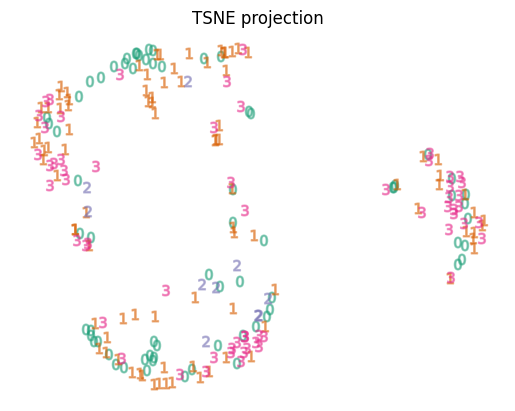

In [43]:
# Compute TSNE projection
tsne = TSNE(n_jobs=-1)
projection = tsne.fit_transform(x_train_kmeans)

# Show result
_, ax = plt.subplots()
for cluster in range(4):
    ax.scatter(
        *projection[y_train == cluster].T,
        marker=f"${cluster}$",
        s=60,
        color=plt.cm.Dark2(cluster),
        alpha=0.425,
        zorder=2,
    )
ax.set_title('TSNE projection')
ax.axis("off");

### Evaluate

In [44]:
def evaluate(model, x_train, y_train, x_valid, y_valid):
    # Predict
    pred_train = model.predict(x_train)
    pred_valid = model.predict(x_valid)

    # Compute metrics
    accuracy_train = accuracy_score(y_train, pred_train)
    accuracy_valid = accuracy_score(y_valid, pred_valid)
    f1_micro_train = f1_score(y_train, pred_train, average='micro')
    f1_micro_valid = f1_score(y_valid, pred_valid, average='micro')
    f1_macro_train = f1_score(y_train, pred_train, average='macro')
    f1_macro_valid = f1_score(y_valid, pred_valid, average='macro')
    f1_weighted_train = f1_score(y_train, pred_train, average='weighted')
    f1_weighted_valid = f1_score(y_valid, pred_valid, average='weighted')

    # Print metrics
    print(f'Training accuracy:      {(accuracy_train*100):.2f} %')
    print(f'Validation accuracy:    {(accuracy_valid*100):.2f} %')
    print()
    print(f'Training F1-micro:      {(f1_micro_train*100):.2f} %')
    print(f'Validation F1-micro:    {(f1_micro_valid*100):.2f} %')
    print()
    print(f'Training F1-macro:      {(f1_macro_train*100):.2f} %')
    print(f'Validation F1-macro:    {(f1_macro_valid*100):.2f} %')
    print()
    print(f'Training F1-weighted:   {(f1_weighted_train*100):.2f} %')
    print(f'Validation F1-weighted: {(f1_weighted_valid*100):.2f} %')
    print()

    # Print label correspondance
    for i in range(4):
        print(i, '=', label_encoder.inverse_transform([i])[0])

    # Show confusion matrix
    cm = confusion_matrix(y_valid, pred_valid)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    
    return (accuracy_train, accuracy_valid, f1_micro_train, f1_micro_valid,
            f1_macro_train, f1_macro_valid, f1_weighted_train, f1_weighted_valid)

Training accuracy:      21.93 %
Validation accuracy:    34.48 %

Training F1-micro:      21.93 %
Validation F1-micro:    34.48 %

Training F1-macro:      20.33 %
Validation F1-macro:    32.35 %

Training F1-weighted:   23.28 %
Validation F1-weighted: 37.47 %

0 = Ленинский
1 = Орджоникидзевский
2 = Орджоникидзевский (левый берег)
3 = Правобережный


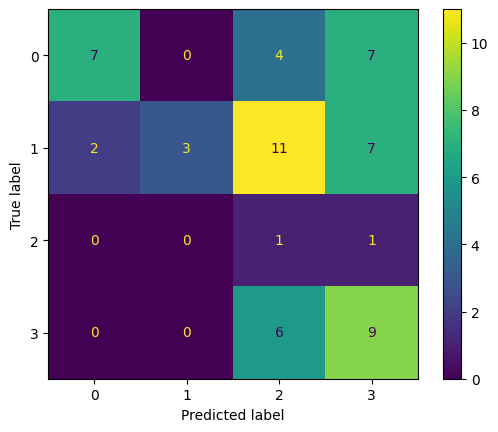

In [45]:
evaluate(kmeans, x_train, y_train, x_valid, y_valid);

**Comments**
___
The result is about random prediction.

## KMeans + Random Forest Classifier
### Fit KMeans

In [46]:
# Train KMeans with the best number of clusters
score = {}
best_score = 0
for i in range(2, 20):
    kmeans = KMeans(n_clusters=i, n_init=4, random_state=RANDOM_STATE)
    kmeans = kmeans.fit(x_train)
    labels = kmeans.labels_
    score[i] = calinski_harabasz_score(x_train, labels)
    if score[i] > best_score:
        best_score = score[i]
        best_kmeans = kmeans
kmeans = best_kmeans
score

{2: 132.30955620437922,
 3: 111.85933079200561,
 4: 109.28279759528989,
 5: 109.37870721483796,
 6: 113.0270762590447,
 7: 114.0710511340596,
 8: 111.23940677087957,
 9: 111.15930293401429,
 10: 113.1429283141787,
 11: 109.80084804146344,
 12: 107.09310651244817,
 13: 108.20523575985148,
 14: 101.21802895370134,
 15: 105.8116109618251,
 16: 99.36492581568118,
 17: 96.56177960587765,
 18: 99.00042593251396,
 19: 99.99815987558236}

### Show TSNE projection

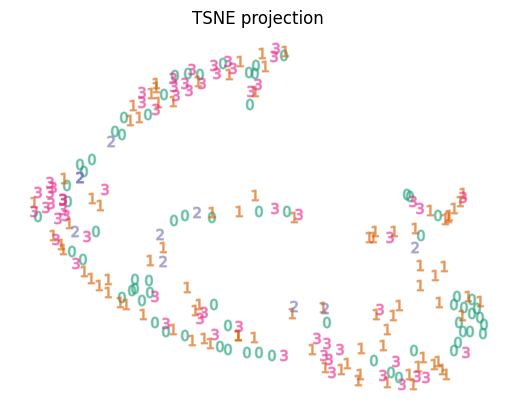

In [47]:
# Compute TSNE projection
tsne = TSNE(n_jobs=-1)
projection = tsne.fit_transform(kmeans.transform(x_train))

# Show result
_, ax = plt.subplots()
for cluster in range(4):
    ax.scatter(
        *projection[y_train == cluster].T,
        marker=f"${cluster}$",
        s=60,
        color=plt.cm.Dark2(cluster),
        alpha=0.425,
        zorder=2,
    )
ax.set_title('TSNE projection')
ax.axis("off");

### Add KMeans data

In [48]:
x_train_kmeans = pd.DataFrame(best_kmeans.transform(x_train), x_train.index, best_kmeans.get_feature_names_out())
x_train = pd.concat([x_train_kmeans, x_train], axis=1)

x_valid_kmeans = pd.DataFrame(best_kmeans.transform(x_valid), x_valid.index, best_kmeans.get_feature_names_out())
x_valid = pd.concat([x_valid_kmeans, x_valid], axis=1)

x_train

,kmeans0,kmeans1,о,ж,к,Цена,Тип квартиры_Двухкомнатная,Тип квартиры_Многокомнатная,Тип квартиры_Однокомнатная,Тип квартиры_Трехкомнатная,Тип квартиры_Четырехкомнатная
id,,,,,,,,,,,
15909831,1.118723,3.623499,1.314458,1.277093,0.021593,1.696687,0.0,0.0,0.0,1.0,0.0
15909830,1.784983,3.766941,1.261430,1.258702,-0.180594,1.947318,0.0,0.0,0.0,0.0,1.0
15927949,3.895128,6.512568,2.640158,2.809637,1.285263,3.625336,0.0,0.0,0.0,1.0,0.0
15926372,3.061221,3.191613,0.709938,-1.971900,0.274327,1.554591,0.0,0.0,0.0,0.0,1.0
15926370,3.697675,1.794068,-0.806663,-1.971900,-0.104774,-0.187692,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
14105037,3.722036,1.299233,-1.273310,-0.807167,-0.736609,-0.944585,0.0,0.0,1.0,0.0,0.0
14046477,0.570681,2.795561,0.635699,0.786679,0.779795,0.983350,0.0,0.0,0.0,1.0,0.0
13463306,0.961561,3.347692,0.996290,1.460998,0.021593,1.340376,0.0,0.0,0.0,1.0,0.0


### Fit Ransom Forest

In [49]:
%%time
rf_model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=RANDOM_STATE)
rf_model.fit(x_train, y_train);

CPU times: user 517 ms, sys: 357 ms, total: 874 ms
Wall time: 119 ms


### Evaluate

Training accuracy:      100.00 %
Validation accuracy:    51.72 %

Training F1-micro:      100.00 %
Validation F1-micro:    51.72 %

Training F1-macro:      100.00 %
Validation F1-macro:    37.39 %

Training F1-weighted:   100.00 %
Validation F1-weighted: 49.64 %

0 = Ленинский
1 = Орджоникидзевский
2 = Орджоникидзевский (левый берег)
3 = Правобережный


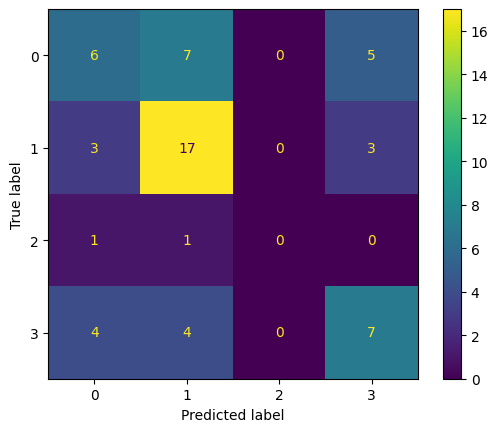

In [50]:
evaluate(rf_model, x_train, y_train, x_valid, y_valid);